1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

# assign a global match index and compute round
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# extract hour from kick-off time and bucket into time-of-day
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# 3.11 Final clean-up (types & safe replacements)

# cast categoricals to string (encoder in Section 4 expects strings)
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns:
        df[c] = df[c].astype(str)

# replace inf/-inf with NaN (imputers in Section 4 handle NaNs safely)
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ensure FormDiff feature exists (home form − away form)
if 'FormDiff' not in df.columns and {'HomeForm3','AwayForm3'}.issubset(df.columns):
    df['FormDiff'] = df['HomeForm3'] - df['AwayForm3']


4. Pipeline Specification & Hyperparameter Distributions

In [4]:
from scipy.stats import uniform, loguniform
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier

# categorical and numerical feature lists remain the same
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] + [f'Away_{s}_3' for s in away_stats]

# guard: keep only existing columns to avoid KeyErrors
_existing = set(df.columns)
_missing = [c for c in cat_feats + num_feats if c not in _existing]
if _missing:
    print("Note: dropping missing features:", _missing)
cat_feats = [c for c in cat_feats if c in _existing]
num_feats = [c for c in num_feats if c in _existing]

# preprocessing pipelines (leakage-safe imputers inside the pipeline)
# numeric: median first, then constant to catch all-NaN columns
numeric_pipe = Pipeline(steps=[
    ('imputer_median', SimpleImputer(strategy='median')),
    ('imputer_const',  SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scaler',         StandardScaler(with_mean=False))
])

# categorical: most_frequent + OHE (new sklearn uses sparse_output)
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# column transformer: numeric + categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_feats),
        ('cat', categorical_pipe, cat_feats),
    ],
    remainder='drop',
    sparse_threshold=1.0
)

# hyperparameter search space for SGDClassifier
param_dist = {
    'clf__loss':          ['log_loss'],  # ensure predict_proba is available
    'clf__penalty':       ['l2', 'l1', 'elasticnet'],
    'clf__alpha':         loguniform(1e-6, 1e-1),
    'clf__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'clf__eta0':          uniform(1e-4, 0.1)
}

# factory to build an online SGD pipeline (one epoch per .fit/partial_fit)
def make_model_sgd():
    return Pipeline([
        ('prep', preprocessor),
        ('clf', SGDClassifier(
            loss='log_loss',
            random_state=42,
            max_iter=1,      # one epoch per fit() call
            tol=None,        # disable internal convergence
            warm_start=True  # keep weights across calls
        ))
    ])


5. Round‐by‐Round Training, Online Prediction & Model Updates

In [5]:
preds, actuals, rounds, match_indices = [], [], [], []
warmup = 50   # initial warm‐up to train the preprocessor + classifier

# 5.0 Automated hyperparameter search on warm-up (no leakage)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.base import clone
import numpy as np

X_warm = df.loc[:warmup-1, cat_feats + num_feats]
y_warm = df.loc[:warmup-1, 'Outcome']

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=make_model_sgd(),
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_log_loss',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X_warm, y_warm)
best_params = search.best_params_
print("Best params on warm-up:", best_params)

# 5.1 Warm‐up: fit the pipeline on the first `warmup` matches using best params
model = make_model_sgd()
model.set_params(**best_params)
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'Outcome']
)

# 5.2 Online loop: predict each new round, then update on that round’s results
from sklearn.metrics import accuracy_score

classes_arr = np.array(sorted(df['Outcome'].unique()))
first_update = True

for r in range(6, df['Round'].max() + 1):
    test_mask = df['Round'] == r
    X_test    = df.loc[test_mask, cat_feats + num_feats]
    y_test    = df.loc[test_mask, 'Outcome']

    # enforce exactly 10 matches per round
    if len(X_test) < 10:
        print(f"Round {r}: skipped (only {len(X_test)} matches).")
        continue
    if len(X_test) > 10:
        X_test = X_test.iloc[:10].copy()
        y_test = y_test.iloc[:10].copy()

    # predict (no learning yet on this round)
    y_pred = model.predict(X_test)

    # collect
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_mask, 'MatchIndex'].iloc[:len(y_test)].tolist())

    # evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: {len(X_test)} matches | accuracy = {acc:.3f}")

    # online update: transform through the preprocessor, then partial_fit
    X_batch = model.named_steps['prep'].transform(X_test)
    if first_update:
        model.named_steps['clf'].partial_fit(X_batch, y_test, classes=classes_arr)
        first_update = False
    else:
        model.named_steps['clf'].partial_fit(X_batch, y_test)

print(f"Predicted rounds 6 to {df['Round'].max()}")

# retain the final online‐trained pipeline for downstream use
final_model = model


Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [ -2.96844148  -1.78798334  -1.48318738  -1.12544322          nan
 -16.32666646  -1.15552443  -2.20733833          nan  -1.14947952
  -1.06990755  -2.18222425  -1.09665085  -1.11304364  -1.13337155
  -1.93028576          nan  -1.13524577          nan  -1.1317002
  -1.20610127  -2.41705464  -1.14645821  -1.13729221          nan]
  warnings.warn(


Best params on warm-up: {'clf__alpha': 8.454394570685005e-05, 'clf__eta0': 0.0016966252220214195, 'clf__learning_rate': 'invscaling', 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet'}
Round 6: 10 matches | accuracy = 0.200
Round 7: 10 matches | accuracy = 0.400
Round 8: 10 matches | accuracy = 0.300
Round 9: 10 matches | accuracy = 0.300
Round 10: 10 matches | accuracy = 0.300
Round 11: 10 matches | accuracy = 0.300
Round 12: 10 matches | accuracy = 0.400
Round 13: 10 matches | accuracy = 0.500
Round 14: 10 matches | accuracy = 0.400
Round 15: 10 matches | accuracy = 0.600
Round 16: 10 matches | accuracy = 0.700
Round 17: 10 matches | accuracy = 0.300
Round 18: 10 matches | accuracy = 0.400
Round 19: 10 matches | accuracy = 0.300
Round 20: 10 matches | accuracy = 0.600
Round 21: 10 matches | accuracy = 0.100
Round 22: 10 matches | accuracy = 0.400
Round 23: 10 matches | accuracy = 0.200
Round 24: 10 matches | accuracy = 0.400
Round 25: 10 matches | accuracy = 0.600
Round 26: 10 ma

6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Per-round summary and saves (project root, not outcome/)
from pathlib import Path
import cloudpickle

SAVE_DIR = Path.cwd()

per_round = results_df.groupby('Round') \
    .apply(lambda g: (g['Actual']==g['Predicted']).mean()) \
    .reset_index(name='Accuracy')

with pd.ExcelWriter(SAVE_DIR / 'sgd_round_predictions_and_summary.xlsx') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Predictions')
    per_round.to_excel(writer, index=False, sheet_name='PerRoundSummary')
print("Saved Excel with sheets: Predictions, PerRoundSummary.")

per_round.to_csv(SAVE_DIR / 'sgd_per_round_accuracy.csv', index=False)
print("Saved per-round accuracy CSV to 'sgd_per_round_accuracy.csv'.")

# 6.3 Save the online‐trained pipeline (pre-calibration, project root)
with open(SAVE_DIR / 'sgd_final_pipeline_precal.pkl', 'wb') as f:
    cloudpickle.dump(final_model, f)
print("Saved pre-calibration pipeline to 'sgd_final_pipeline_precal.pkl' (cloudpickle).")

# 6.4 Probability calibration (trained, automated, no manual post-processing)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

X_train_all = df[cat_feats + num_feats]
y_train_all = df['Outcome']

base_clf = SGDClassifier(
    loss='log_loss',
    random_state=42,
    max_iter=1000,
    tol=1e-3,
    warm_start=False
)

# apply best hyperparameters found on warm-up
if 'best_params' in globals():
    if 'clf__penalty' in best_params:       base_clf.set_params(penalty=best_params['clf__penalty'])
    if 'clf__alpha' in best_params:         base_clf.set_params(alpha=best_params['clf__alpha'])
    if 'clf__learning_rate' in best_params: base_clf.set_params(learning_rate=best_params['clf__learning_rate'])
    if 'clf__eta0' in best_params:          base_clf.set_params(eta0=best_params['clf__eta0'])

# stronger calibration to avoid overconfident probabilities
calibrated = CalibratedClassifierCV(
    estimator=base_clf,
    method='isotonic',
    cv=5
)

final_model = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf',  calibrated)
])

final_model.fit(X_train_all, y_train_all)

with open(SAVE_DIR / 'sgd_final_pipeline.pkl', 'wb') as f:
    cloudpickle.dump(final_model, f)
print("Saved calibrated final pipeline to 'sgd_final_pipeline.pkl' (cloudpickle).")


C:\Users\markf\AppData\Local\Temp\ipykernel_25016\1929985918.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['Actual']==g['Predicted']).mean()) \


Saved Excel with sheets: Predictions, PerRoundSummary.
Saved per-round accuracy CSV to 'sgd_per_round_accuracy.csv'.
Saved pre-calibration pipeline to 'sgd_final_pipeline_precal.pkl' (cloudpickle).
Saved calibrated final pipeline to 'sgd_final_pipeline.pkl' (cloudpickle).


7. Results & Visualization

Overall accuracy = 0.442


C:\Users\markf\AppData\Local\Temp\ipykernel_25016\2728310686.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


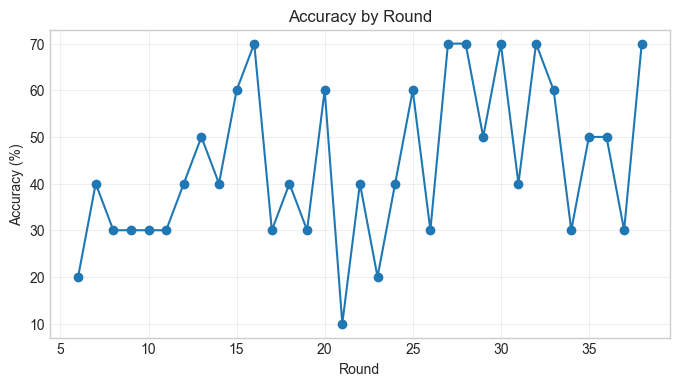

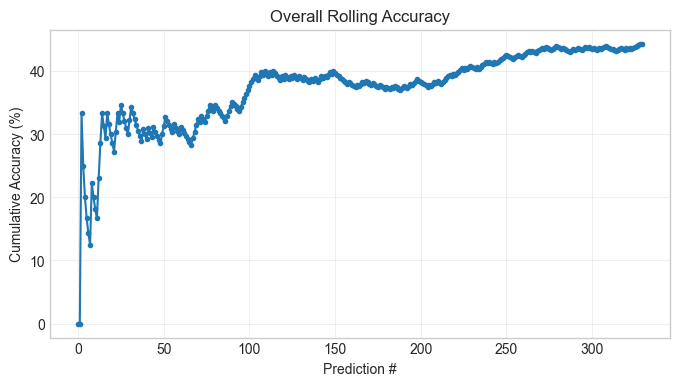

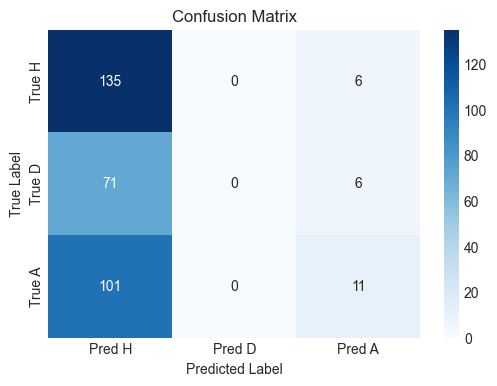

              precision    recall  f1-score   support

    Home win       0.44      0.96      0.60       141
        Draw       0.00      0.00      0.00        77
    Away win       0.48      0.10      0.16       112

    accuracy                           0.44       330
   macro avg       0.31      0.35      0.26       330
weighted avg       0.35      0.44      0.31       330



c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 7.0 Overall accuracy (text)
from sklearn.metrics import accuracy_score

if 'actuals' in globals() and 'preds' in globals() and len(actuals) == len(preds) and len(actuals) > 0:
    overall_acc = accuracy_score(actuals, preds)
elif 'predictions_df' in globals() and {'y_true','y_pred'}.issubset(predictions_df.columns) and len(predictions_df) > 0:
    overall_acc = (predictions_df['y_true'] == predictions_df['y_pred']).mean()
else:
    overall_acc = float('nan')

print(f"Overall accuracy = {overall_acc:.3f}")


# 7.1 Round-by-round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))
plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# 7.2 Cumulative accuracy
correct = np.array(preds) == np.array(actuals)
cum_acc = np.cumsum(correct) / np.arange(1, len(correct) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

# 7.3 Confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred H','Pred D','Pred A'],
            yticklabels=['True H','True D','True A'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7.4 Classification report
print(classification_report(actuals, preds,
      labels=[1,0,-1],
      target_names=['Home win','Draw','Away win']))



8. Gradio Interface

In [8]:
import os, cloudpickle
import numpy as np
import pandas as pd
import gradio as gr

# 8.0 Load trained pipeline
if 'best_pipeline' not in globals():
    if os.path.exists("sgd_final_pipeline.pkl"):
        with open("sgd_final_pipeline.pkl", "rb") as f:
            best_pipeline = cloudpickle.load(f)
    elif 'final_model' in globals():
        best_pipeline = final_model
    else:
        raise RuntimeError("Trained pipeline not found. Run Sections 5–6 first.")

# 8.0.b Ensure df exists for UI
if 'df' not in globals():
    if os.path.exists('df_processed.parquet'):
        df = pd.read_parquet('df_processed.parquet')
    elif os.path.exists('df_processed.csv'):
        df = pd.read_csv('df_processed.csv')
    else:
        raise RuntimeError("Dataframe 'df' not found. Run Sections 2–3 first or save the processed dataframe.")

# 8.1 Precompute odds-derived feature means
odd_feats = ['ImpProb_H','ImpProb_D','ImpProb_A','ImpOver2.5','ImpUnder2.5','OddsSpread']
odd_means = df[odd_feats].mean(numeric_only=True) if set(odd_feats).issubset(df.columns) else pd.Series(dtype=float)

# 8.2 Dropdown choices
teams = sorted(pd.unique(pd.concat([df['HomeTeam'].astype(str), df['AwayTeam'].astype(str)])))
refs  = sorted(df['Referee'].astype(str).unique())
times = ['Morning','Afternoon','Evening']

# 8.3 Rolling-stats lists (used in predict function)
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']

# 8.4 Prediction function
def predict_outcome(home_team, away_team, referee, time_of_day):
    data = {}

    # categoricals
    data['HomeTeam']  = str(home_team)
    data['AwayTeam']  = str(away_team)
    data['Referee']   = str(referee)
    data['TimeOfDay'] = str(time_of_day)

    # latest rows for the selected entities
    hrows = df[df['HomeTeam'] == home_team]
    arows = df[df['AwayTeam'] == away_team]
    rrows = df[df['Referee']  == referee]
    hrow  = hrows.iloc[-1] if len(hrows) else pd.Series(dtype=object)
    arow  = arows.iloc[-1] if len(arows) else pd.Series(dtype=object)
    rrow  = rrows.iloc[-1] if len(rrows) else pd.Series(dtype=object)

    # odds-derived features (use training means in UI)
    for s in odd_feats:
        if s in df.columns:
            data[s] = float(odd_means.get(s, np.nan))

    # home-side numeric features
    for s in ['HomeForm3','HomeStreak','HomePosPrev'] + [f'Home_{s}_3' for s in home_stats]:
        if s in df.columns and s in hrow.index:
            data[s] = hrow[s]

    # away-side numeric features
    for s in ['AwayForm3','AwayStreak','AwayPosPrev'] + [f'Away_{s}_3' for s in away_stats]:
        if s in df.columns and s in arow.index:
            data[s] = arow[s]

    # referee bias
    if 'RefBias' in df.columns and 'RefBias' in rrow.index:
        data['RefBias'] = rrow['RefBias']
    elif 'RefBias' in df.columns:
        data['RefBias'] = 0.5

    # last head-to-head
    if 'H2H_Last' in df.columns:
        pair = tuple(sorted([home_team, away_team]))
        pairs = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
        hits = df.loc[pairs[pairs == pair].index]
        data['H2H_Last'] = hits['H2H_Last'].iloc[-1] if len(hits) else 0.0

    # engineered: Spread×Form, FormDiff
    if ('Spread×Form' in df.columns) or ('num_feats' in globals() and 'Spread×Form' in num_feats):
        hf  = data.get('HomeForm3', np.nan)
        spr = data.get('OddsSpread', np.nan)
        data['Spread×Form'] = (hf * spr) if (pd.notna(hf) and pd.notna(spr)) else np.nan
    if ('FormDiff' in df.columns) or ('num_feats' in globals() and 'FormDiff' in num_feats):
        hf = data.get('HomeForm3', np.nan)
        af = data.get('AwayForm3', np.nan)
        data['FormDiff'] = (hf - af) if (pd.notna(hf) and pd.notna(af)) else np.nan

    # assemble single-row DataFrame
    X = pd.DataFrame([data])

    # ensure expected features exist and are aligned
    expected = []
    if 'cat_feats' in globals(): expected += list(cat_feats)
    if 'num_feats' in globals(): expected += list(num_feats)
    if not expected:
        try:
            pre = best_pipeline.named_steps.get('prep') or best_pipeline.named_steps.get('pre')
            expected = list(pre.transformers_[0][2]) + list(pre.transformers_[1][2])
        except Exception:
            expected = list(X.columns)

    # create FormDiff if expected but missing
    if 'FormDiff' in expected and 'FormDiff' not in X.columns:
        if {'HomeForm3','AwayForm3'}.issubset(X.columns):
            X['FormDiff'] = X['HomeForm3'] - X['AwayForm3']
        else:
            X['FormDiff'] = np.nan

    # add any missing expected columns as NaN; reindex to expected order
    for c in expected:
        if c not in X.columns:
            X[c] = np.nan
    X = X.reindex(columns=expected, fill_value=np.nan)

    # model probabilities (calibrated), map to H/D/A and normalize to 100%
    probs = best_pipeline.predict_proba(X)[0]
    classes = list(best_pipeline.classes_)

    def get_prob(cls_num, cls_chr):
        if cls_num in classes: return probs[classes.index(cls_num)]
        if cls_chr in classes: return probs[classes.index(cls_chr)]
        return 0.0

    pH = get_prob(1, 'H'); pD = get_prob(0, 'D'); pA = get_prob(-1, 'A')
    p = np.array([pH, pD, pA], dtype=float)
    p = np.clip(p, 0, None); s = p.sum()
    p = (np.ones(3)/3) if (not np.isfinite(s) or s<=0) else (p/s)

    H_pct = float(np.round(p[0]*100, 2))
    D_pct = float(np.round(p[1]*100, 2))
    A_pct = float(np.round(100.0 - H_pct - D_pct, 2))
    return H_pct, D_pct, A_pct

# 8.5 Gradio UI
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Radio(choices=times,    label="Time of Day", value='Afternoon'),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %"),
    ],
    title="Premier League Outcome Predictor (SGD Online)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features use historical averages; other features come from the latest matches."
    )
)

iface.launch() 


* Running on local URL:  http://127.0.0.1:7860


ValueError: When localhost is not accessible, a shareable link must be created. Please set share=True or check your proxy settings to allow access to localhost.